In [1]:
#!pip install torch torchaudio scikit-learn numpy
#!pip install soundfile

# IMPORT

In [2]:
import os
from collections import Counter

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from src.preprocessing.dataset import (
    list_ravdess_files,
    filter_audio_speech,
    RavdessDataset,
    extract_label_idx,
    IDX2LABEL,
)
from src.models.crnn import CRNN
from src.utils import set_seed, evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from src.visual_analysis.visual_analysis import *

from sklearn.model_selection import GroupKFold
import numpy as np


# DEFINIZIONE DATA BASE

In [3]:

set_seed(42)

DATA_ROOT = "./data"
EPOCHS = 50
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4
N_FOLDS = 6

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1) lista file
all_files = list_ravdess_files(DATA_ROOT)
all_files = filter_audio_speech(all_files)
if len(all_files) == 0:
    raise RuntimeError("Nessun file trovato. Controlla DATA_ROOT e filter_audio_speech().")

# 2) labels per stratify
labels = [extract_label_idx(fp) for fp in all_files]
print("Tot files:", len(all_files))
print("Distribuzione classi:", Counter(labels))


Device: cuda
Tot files: 1440
Distribuzione classi: Counter({1: 192, 2: 192, 3: 192, 4: 192, 5: 192, 6: 192, 7: 192, 0: 96})


# SPLIT DATASET

In [4]:
# serve per vedere se stai usando la CPU o se hai CUDA
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))

# IMPORTANTE
# se qui la prima riga ti ritorna True allora sotto quando scrivi i DataLoader metti i pinmemory = True

CUDA available: True
Device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
from src.preprocessing.dataset import parse_ravdess_filename

def split_by_speakers(filepaths, train_speakers, val_speakers, test_speakers):
    train, val, test = [], [], []
    for fp in filepaths:
        actor = parse_ravdess_filename(fp)["actor"]
        if actor in train_speakers:
            train.append(fp)
        elif actor in val_speakers:
            val.append(fp)
        elif actor in test_speakers:
            test.append(fp)
    return train, val, test


# Funzione per Mixup
def mixup_data(x, y, alpha=0.2, device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [6]:
actors = [parse_ravdess_filename(fp)["actor"] for fp in all_files]

print(f"Tot files: {len(all_files)}")
print(f"Distribuzione classi: {Counter(labels)}")
print(f"Numero attori unici: {len(set(actors))}")
gkf = GroupKFold(n_splits=N_FOLDS)

# Lista per salvare i risultati di ogni fold
fold_results = []

print(f"\n{'='*60}")
print(f"CROSS-VALIDATION CON {N_FOLDS} FOLDS (SPEAKER-INDEPENDENT)")
print(f"{'='*60}\n")

for fold_idx, (train_val_idx, test_idx) in enumerate(gkf.split(all_files, labels, groups=actors)):
    
    print(f"\n{'='*60}")
    print(f"FOLD {fold_idx + 1}/{N_FOLDS}")
    print(f"{'='*60}")
    
    # =====================================================
    # A) SPLIT DEI FILE
    # =====================================================
    
    # Test set per questo fold (speaker completamente separati)
    test_files = [all_files[i] for i in test_idx]
    train_val_files = [all_files[i] for i in train_val_idx]
    
    # Estrai info per train_val
    train_val_actors = [actors[i] for i in train_val_idx]
    train_val_labels = [labels[i] for i in train_val_idx]
    
    # Test actors
    test_actors = sorted(set([actors[i] for i in test_idx]))
    
    # =====================================================
    # B) ULTERIORE SPLIT TRAIN/VAL (speaker-independent anche qui)
    # =====================================================
    
    unique_train_val_actors = list(set(train_val_actors))
    val_size = max(2, len(unique_train_val_actors) // 6)  # ~15-17% per validation
    
    # Bilanciamento per genere (RAVDESS: dispari=M, pari=F)
    male_actors_tv = [a for a in unique_train_val_actors if int(a) % 2 == 1]
    female_actors_tv = [a for a in unique_train_val_actors if int(a) % 2 == 0]
    
    # Scegli attori per validation bilanciati per genere
    import random
    random.seed(42 + fold_idx)  # Seed diverso per ogni fold
    
    val_actors = (
        random.sample(male_actors_tv, min(val_size // 2, len(male_actors_tv))) +
        random.sample(female_actors_tv, min(val_size // 2, len(female_actors_tv)))
    )
    train_actors = [a for a in unique_train_val_actors if a not in val_actors]
    
    # Dividi i file
    train_files = [f for f, a in zip(train_val_files, train_val_actors) if a in train_actors]
    val_files = [f for f, a in zip(train_val_files, train_val_actors) if a in val_actors]
    
    print(f"Train: {len(train_files)} files, {len(train_actors)} speakers {sorted(train_actors)}")
    print(f"Val:   {len(val_files)} files, {len(val_actors)} speakers {sorted(val_actors)}")
    print(f"Test:  {len(test_files)} files, {len(test_actors)} speakers {test_actors}")
    
    # =====================================================
    # C) CLASS WEIGHTS
    # =====================================================
    
    train_labels_fold = [extract_label_idx(fp) for fp in train_files]
    counts = Counter(train_labels_fold)
    
    weights = torch.tensor([1.0 / counts[i] for i in range(8)], dtype=torch.float, device=device)
    weights = weights / weights.sum() * 8
    
    print(f"Class counts: {counts}")
    print(f"Weights: {weights.detach().cpu().numpy().round(3)}")
    
    # =====================================================
    # D) DATASET E DATALOADER
    # =====================================================
    
    AUG_ON = True
    
    aug_cfg = {
        "gain": True,          # Abilitato
        "gain_db": (-3, 3),    # Range più ampio
        
        "time_shift": True,    
        "time_shift_s": 0.05,  # Più generoso
        
        "noise": True,
        "snr_db": (25, 40),    # SNR più realistico
        
        "vtlp": False,

        "reverb": False,        # Abilitato
        "reverb_ir_s": 0.08,
        "reverb_decay": 0.3,
    }
    
    train_ds = RavdessDataset(train_files, augmentation=AUG_ON, aug_config=aug_cfg)
    val_ds   = RavdessDataset(val_files,   augmentation=False)
    test_ds  = RavdessDataset(test_files,  augmentation=False)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, pin_memory=True)
    
    # =====================================================
    # E) MODEL, OPTIMIZER, SCHEDULER
    # =====================================================
    
    model = CRNN(n_classes=8, n_mels=64).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=6
    )
    
    best_val_acc = 0.0
    best_path = f"best_fold_{fold_idx}.pt"  # Path diverso per ogni fold
    
    # History per questo fold
    val_acc_hist = []
    test_acc_hist = []

    print(f"\nInizio training fold {fold_idx + 1}...")
    
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0
        
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            logits = model(x)
            loss = torch.nn.functional.cross_entropy(
                logits, y, weight=weights, label_smoothing=0.1
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            
            running_loss += loss.item() * y.size(0)
            running_correct += (logits.argmax(dim=1) == y).sum().item()
            total += y.size(0)
        
        train_loss = running_loss / total
        train_acc = running_correct / total
        
        val_loss, val_acc = evaluate(model, val_loader, device)
        test_loss_epoch, test_acc_epoch = evaluate(model, test_loader, device)
        
        scheduler.step(val_acc)
        
        val_acc_hist.append(val_acc)
        test_acc_hist.append(test_acc_epoch)
        
        # Print ogni 5 epoche
        if epoch % 5 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:3d}/{EPOCHS} | "
                f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
                f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
                f"test acc {test_acc_epoch:.4f}"
            )
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_path)

    # =====================================================
    # G) VALUTAZIONE FINALE DEL FOLD
    # =====================================================
    
    # Carica il miglior modello
    model.load_state_dict(torch.load(best_path, map_location=device))
    
    final_test_loss, final_test_acc = evaluate(model, test_loader, device)
    
    print(f"\n{'='*60}")
    print(f"RISULTATI FOLD {fold_idx + 1}")
    print(f"{'='*60}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Test Accuracy:      {final_test_acc:.4f}")
    
    # Classification report
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x).cpu()
            preds = logits.argmax(dim=1).numpy().tolist()
            y_pred.extend(preds)
            y_true.extend(y.numpy().tolist())
    
    print("\nClassification Report:")
    target_names = [IDX2LABEL[i] for i in range(8)]
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
    
    # =====================================================
    # H) SALVA RISULTATI DEL FOLD
    # =====================================================
    
    fold_results.append({
        'fold': fold_idx,
        'test_speakers': test_actors,
        'val_speakers': sorted(val_actors),
        'train_speakers': sorted(train_actors),
        'best_val_acc': best_val_acc,
        'final_test_acc': final_test_acc,
        'val_acc_history': val_acc_hist,
        'test_acc_history': test_acc_hist,
        'y_true': y_true,
        'y_pred': y_pred,
        'confusion_matrix': confusion_matrix(y_true, y_pred),
    })

Tot files: 1440
Distribuzione classi: Counter({1: 192, 2: 192, 3: 192, 4: 192, 5: 192, 6: 192, 7: 192, 0: 96})
Numero attori unici: 24

CROSS-VALIDATION CON 6 FOLDS (SPEAKER-INDEPENDENT)


FOLD 1/6
Train: 1080 files, 18 speakers ['02', '03', '04', '05', '07', '08', '09', '10', '11', '13', '14', '15', '17', '19', '20', '21', '22', '23']
Val:   120 files, 2 speakers ['01', '16']
Test:  240 files, 4 speakers ['06', '12', '18', '24']
Class counts: Counter({1: 144, 2: 144, 3: 144, 4: 144, 5: 144, 6: 144, 7: 144, 0: 72})
Weights: [1.778 0.889 0.889 0.889 0.889 0.889 0.889 0.889]

Inizio training fold 1...
Epoch   1/50 | train loss 2.0918 acc 0.1241 | val loss 2.0695 acc 0.1333 | test acc 0.1333
Epoch   5/50 | train loss 1.8990 acc 0.2833 | val loss 1.6963 acc 0.4167 | test acc 0.3750
Epoch  10/50 | train loss 1.7531 acc 0.3731 | val loss 1.6435 acc 0.3583 | test acc 0.3833
Epoch  15/50 | train loss 1.6099 acc 0.4426 | val loss 1.4110 acc 0.5000 | test acc 0.4667


KeyboardInterrupt: 

Epoch 1/70 | train loss 1.9952 acc 0.2463 | val loss 2.0539 acc 0.1167 | test acc 0.1333
Epoch 2/70 | train loss 1.8579 acc 0.2991 | val loss 1.9509 acc 0.2250 | test acc 0.1833
Epoch 3/70 | train loss 1.7841 acc 0.3370 | val loss 2.4318 acc 0.1333 | test acc 0.1333
Epoch 4/70 | train loss 1.7076 acc 0.3843 | val loss 2.2187 acc 0.2083 | test acc 0.1750
Epoch 5/70 | train loss 1.6604 acc 0.4361 | val loss 1.6511 acc 0.3875 | test acc 0.3500
Epoch 6/70 | train loss 1.6015 acc 0.4833 | val loss 2.2019 acc 0.2292 | test acc 0.1833
Epoch 7/70 | train loss 1.5255 acc 0.5009 | val loss 1.9936 acc 0.3125 | test acc 0.3500
Epoch 8/70 | train loss 1.4522 acc 0.5333 | val loss 1.7610 acc 0.3750 | test acc 0.2917
Epoch 9/70 | train loss 1.4424 acc 0.5472 | val loss 2.6773 acc 0.2375 | test acc 0.2167
Epoch 10/70 | train loss 1.3683 acc 0.5991 | val loss 1.6797 acc 0.3500 | test acc 0.3333
Epoch 11/70 | train loss 1.3448 acc 0.5907 | val loss 1.7849 acc 0.3875 | test acc 0.4750
Epoch 12/70 | train

KeyboardInterrupt: 


RISULTATI FINALI CROSS-VALIDATION (8 FOLDS)

Risultati per fold:
Fold   Val Acc    Test Acc   Test Speakers
----------------------------------------------------------------------
1      0.5583     0.7056     ['08', '16', '24']
2      0.8333     0.5500     ['09', '17', '23']
3      0.5750     0.6556     ['02', '10', '18']
4      0.6917     0.6056     ['03', '11', '19']
5      0.6250     0.6444     ['04', '12', '20']
6      0.6417     0.4222     ['05', '13', '21']
7      0.8000     0.6111     ['06', '14', '22']
8      0.5667     0.5611     ['01', '07', '15']

MEDIA ± STD:
  Validation Acc: 0.6615 ± 0.0990
  Test Acc:       0.5944 ± 0.0804


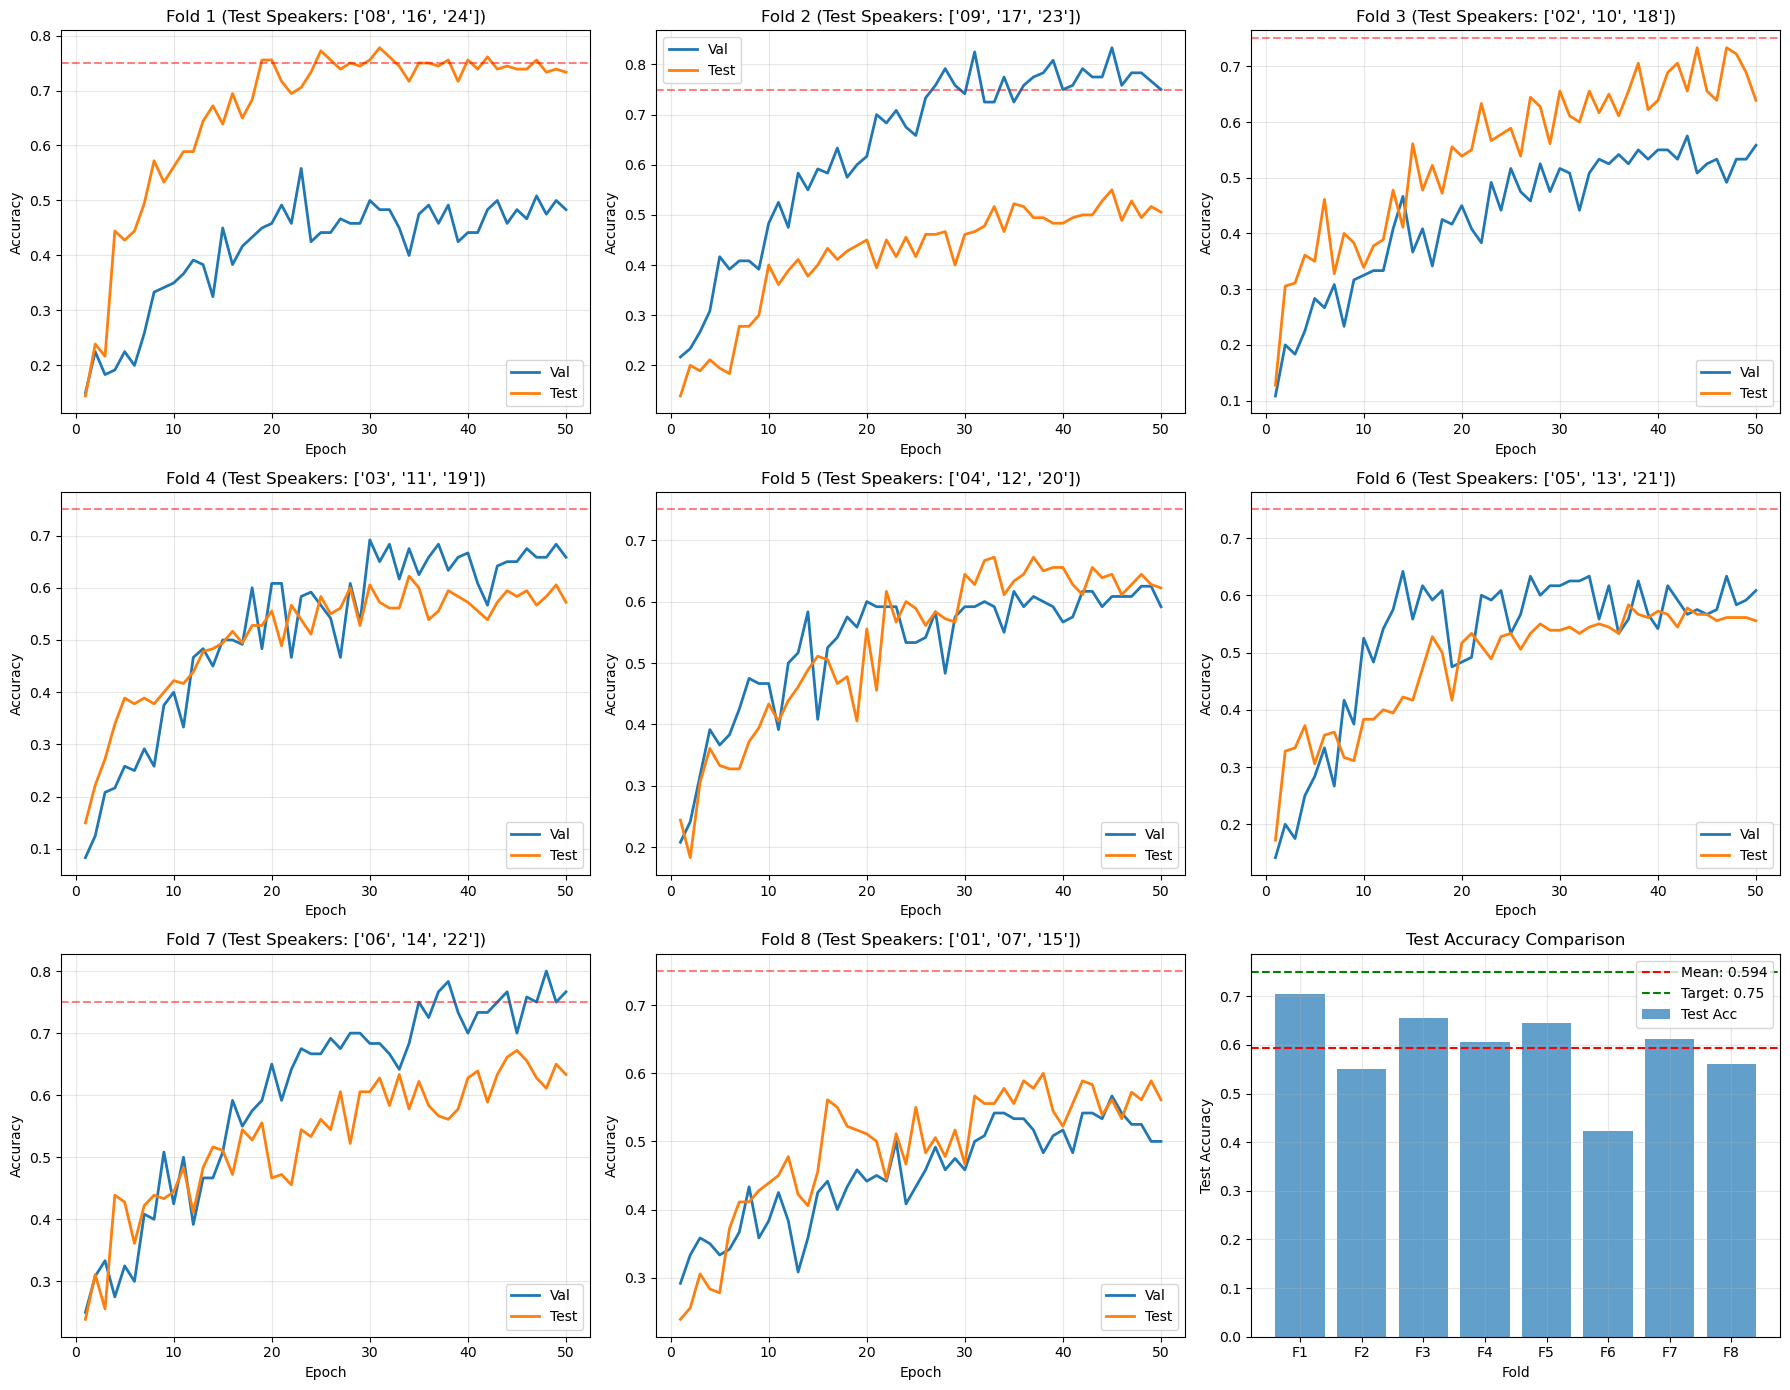

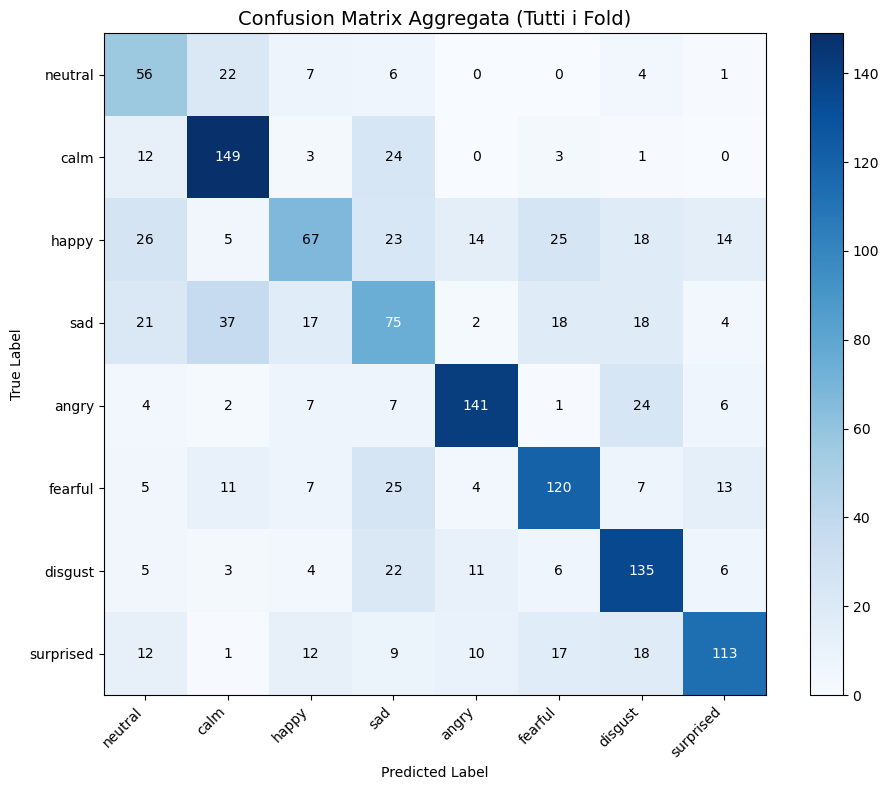


Classification Report Aggregato (Tutti i Fold):
              precision    recall  f1-score   support

     neutral     0.3972    0.5833    0.4726        96
        calm     0.6478    0.7760    0.7062       192
       happy     0.5403    0.3490    0.4241       192
         sad     0.3927    0.3906    0.3916       192
       angry     0.7747    0.7344    0.7540       192
     fearful     0.6316    0.6250    0.6283       192
     disgust     0.6000    0.7031    0.6475       192
   surprised     0.7197    0.5885    0.6476       192

    accuracy                         0.5944      1440
   macro avg     0.5880    0.5938    0.5840      1440
weighted avg     0.6007    0.5944    0.5914      1440


PERFORMANCE PER SPEAKER (quando usato come test set):
Speaker 05 (M): 0.4222
Speaker 13 (M): 0.4222
Speaker 21 (M): 0.4222
Speaker 09 (M): 0.5500
Speaker 17 (M): 0.5500
Speaker 23 (M): 0.5500
Speaker 01 (M): 0.5611
Speaker 07 (M): 0.5611
Speaker 15 (M): 0.5611
Speaker 03 (M): 0.6056
Speaker 11 (M):

In [9]:
print(f"\n{'='*70}")
print(f"RISULTATI FINALI CROSS-VALIDATION ({N_FOLDS} FOLDS)")
print(f"{'='*70}\n")

# Estrai metriche
test_accs = [r['final_test_acc'] for r in fold_results]
val_accs = [r['best_val_acc'] for r in fold_results]

print("Risultati per fold:")
print(f"{'Fold':<6} {'Val Acc':<10} {'Test Acc':<10} {'Test Speakers'}")
print("-" * 70)
for r in fold_results:
    print(f"{r['fold']+1:<6} {r['best_val_acc']:<10.4f} {r['final_test_acc']:<10.4f} {r['test_speakers']}")

print("\n" + "=" * 70)
print(f"MEDIA ± STD:")
print(f"  Validation Acc: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")
print(f"  Test Acc:       {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
print("=" * 70)

# %%
# STEP 6: VISUALIZZAZIONI

# 6A) Plot accuracy per fold
rows = 3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 14))
axes = axes.flatten()

for idx, r in enumerate(fold_results):
    ax = axes[idx]
    epochs_range = range(1, len(r['val_acc_history']) + 1)
    ax.plot(epochs_range, r['val_acc_history'], label='Val', linewidth=2)
    ax.plot(epochs_range, r['test_acc_history'], label='Test', linewidth=2)
    ax.set_title(f"Fold {r['fold']+1} (Test Speakers: {r['test_speakers']})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0.75, color='r', linestyle='--', alpha=0.5, label='Target 0.75')

# Ultimo subplot: confronto finale
ax = axes[-1]
x_pos = np.arange(N_FOLDS)
ax.bar(x_pos, test_accs, alpha=0.7, label='Test Acc')
ax.axhline(y=np.mean(test_accs), color='r', linestyle='--', 
           label=f'Mean: {np.mean(test_accs):.3f}')
ax.axhline(y=0.75, color='g', linestyle='--', label='Target: 0.75')
ax.set_xlabel('Fold')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'F{i+1}' for i in range(N_FOLDS)])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6B) Confusion Matrix aggregata (tutti i fold insieme)
all_y_true = []
all_y_pred = []
for r in fold_results:
    all_y_true.extend(r['y_true'])
    all_y_pred.extend(r['y_pred'])

cm = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Aggregata (Tutti i Fold)', fontsize=14)
plt.colorbar()

tick_marks = np.arange(8)
target_names = [IDX2LABEL[i] for i in range(8)]
plt.xticks(tick_marks, target_names, rotation=45, ha='right')
plt.yticks(tick_marks, target_names)

# Aggiungi numeri nelle celle
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nClassification Report Aggregato (Tutti i Fold):")
print(classification_report(all_y_true, all_y_pred, target_names=target_names, digits=4))

# %%
# STEP 7: ANALISI SPEAKER-SPECIFIC
# Vedi quali speaker sono più difficili da classificare

speaker_performance = {}
for r in fold_results:
    test_spk = r['test_speakers']
    test_acc = r['final_test_acc']
    for spk in test_spk:
        if spk not in speaker_performance:
            speaker_performance[spk] = []
        speaker_performance[spk].append(test_acc)

# Calcola media per speaker (se testato in più fold)
speaker_avg = {spk: np.mean(accs) for spk, accs in speaker_performance.items()}
speaker_sorted = sorted(speaker_avg.items(), key=lambda x: x[1])

print("\n" + "=" * 70)
print("PERFORMANCE PER SPEAKER (quando usato come test set):")
print("=" * 70)
for spk, avg_acc in speaker_sorted:
    gender = "F" if int(spk) % 2 == 0 else "M"
    print(f"Speaker {spk} ({gender}): {avg_acc:.4f}")

print("\nNOTA: Speaker con performance molto diverse potrebbero indicare")
print("      caratteristiche vocali particolarmente distintive o difficili.")

In [ ]:

# VISUAL ANALYSIS
# t-SNE on embeddings + Grad-CAM su spettrogrammi

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from src.preprocessing.dataset import IDX2LABEL, parse_ravdess_filename

#t-SNE on embeddings 
@torch.no_grad()
def extract_crnn_embeddings(model, loader, device, return_paths=True):
    """
    Estrae embeddings dal CRNN SENZA modificare la classe.
    Qui definiamo "embedding" come il vettore dopo:
    CNN -> BiLSTM -> mean pooling temporale, prima del classifier.
    
    Ritorna:
      - emb: [N, D] numpy
      - y_true: [N] numpy
      - y_pred: [N] numpy
      - paths: lista file (opzionale)
    """
    model.eval()
    embs = []
    ys = []
    preds = []
    paths = []

    # Se il tuo Dataset non restituisce il path, lo ricaviamo via loader.dataset.filepaths
    # assumendo che loader NON shuffli (true per val/test nel tuo notebook)
    dataset_paths = getattr(loader.dataset, "filepaths", None)
    global_index = 0

    for batch in loader:
        x, y = batch
        x = x.to(device)

        # --- ricostruzione "forward fino all'embedding" basata sulla tua CRNN ---
        feat = model.cnn(x)                      # [B, C, M', T']
        b, c, m, t = feat.shape
        feat = feat.permute(0, 3, 1, 2).contiguous()  # [B, T', C, M']
        feat = feat.view(b, t, c * m)                 # [B, T', C*M']
        seq, _ = model.rnn(feat)                      # [B, T', 2H]
        emb = seq.mean(dim=1)                         # [B, 2H]  <-- embedding

        logits = model.classifier(emb)                # [B, n_classes]
        y_hat = logits.argmax(dim=1)

        embs.append(emb.detach().cpu())
        ys.append(y.detach().cpu())
        preds.append(y_hat.detach().cpu())

        if return_paths and dataset_paths is not None:
            bs = y.size(0)
            paths.extend(dataset_paths[global_index: global_index + bs])
            global_index += bs

    embs = torch.cat(embs, dim=0).numpy()
    ys = torch.cat(ys, dim=0).numpy()
    preds = torch.cat(preds, dim=0).numpy()

    return embs, ys, preds, paths


def tsne_project(embeddings, pca_dim=50, tsne_perplexity=30, tsne_lr="auto", seed=42):
    """
    PCA (opzionale) + t-SNE -> 2D
    """
    X = embeddings
    if pca_dim is not None and X.shape[1] > pca_dim:
        X = PCA(n_components=pca_dim, random_state=seed).fit_transform(X)

    tsne = TSNE(
        n_components=2,
        perplexity=tsne_perplexity,
        learning_rate=tsne_lr,
        init="pca",
        random_state=seed
    )
    Z = tsne.fit_transform(X)
    return Z


def plot_tsne_by_label(Z, y_true, title="t-SNE (colored by true label)"):
    plt.figure(figsize=(10, 7))
    for k in np.unique(y_true):
        idx = (y_true == k)
        plt.scatter(Z[idx, 0], Z[idx, 1], s=18, alpha=0.75, label=IDX2LABEL[int(k)])
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.legend(markerscale=1.2, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_tsne_errors_and_speakers(Z, y_true, y_pred, paths, title="t-SNE (errors + speaker id)"):
    """
    Plot originale: evidenziamo errori e aggiungiamo speaker id.
    - corretto: marker 'o'
    - errato: marker 'x'
    Colore: emotion vera
    """
    correct = (y_true == y_pred)

    # Speaker/actor id dal filename (RAVDESS Actor_XX)
    speakers = []
    for fp in paths:
        actor = parse_ravdess_filename(fp)["actor"]
        speakers.append(actor)
    speakers = np.array(speakers)

    plt.figure(figsize=(10, 7))

    # Per non avere 24 legende, mettiamo speaker id come testo solo per alcuni punti (campionamento)
    # e ci concentriamo su errori vs corretti
    for k in np.unique(y_true):
        idx_k = (y_true == k)

        # corretti
        idx_ok = idx_k & correct
        plt.scatter(Z[idx_ok, 0], Z[idx_ok, 1], s=16, alpha=0.65, marker="o")

        # errati
        idx_bad = idx_k & (~correct)
        if idx_bad.any():
            plt.scatter(Z[idx_bad, 0], Z[idx_bad, 1], s=40, alpha=0.9, marker="x")

    # Aggiungi qualche speaker label sui punti sbagliati (molto utile per capire leakage)
    bad_idx = np.where(~correct)[0]
    for i in bad_idx[:30]:  # limita per non “sporcare” il grafico
        plt.text(Z[i, 0], Z[i, 1], speakers[i], fontsize=8, alpha=0.85)

    plt.title(title + "  (x = misclassified; text = speaker id on some errors)")
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.tight_layout()
    plt.show()

#Grad-CAM on spectrograms
def find_last_conv2d(module: nn.Module):
    """
    Trova automaticamente l'ultimo nn.Conv2d dentro un modello (o sotto-moduli).
    Così se cambi architettura, spesso non devi cambiare nulla.
    """
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise RuntimeError("Nessun nn.Conv2d trovato: non posso fare Grad-CAM.")
    return last


class GradCAM:
    """
    Grad-CAM generico:
    - hook su ultimo Conv2d (o quello che passi tu)
    - produce heatmap (H x W) allineata allo spettrogramma input
    """
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_a = target_layer.register_forward_hook(self._forward_hook)
        self.hook_g = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out  # [B, C, H, W]

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # [B, C, H, W]

    def close(self):
        self.hook_a.remove()
        self.hook_g.remove()

    def __call__(self, x, class_idx=None):
        import torch.nn as nn
        import torch.nn.functional as F

        # salva stato originale
        was_training = self.model.training

        # serve per far funzionare backward su cuDNN LSTM
        self.model.train()

        # disattiva dropout per mappe stabili
        for m in self.model.modules():
            if isinstance(m, nn.Dropout):
                m.eval()

        self.model.zero_grad(set_to_none=True)

        logits = self.model(x)  # [1, n_classes]
        if class_idx is None:
            class_idx = int(logits.argmax(dim=1).item())

        score = logits[:, class_idx].sum()
        score.backward(retain_graph=True)

        # attivazioni e gradienti dal layer target
        A = self.activations          # [1, C, H, W]
        G = self.gradients            # [1, C, H, W]
        if A is None or G is None:
            raise RuntimeError("Hooks Grad-CAM non hanno catturato activations/gradients. Controlla target_layer.")

        # pesi: global average pooling dei gradienti
        weights = G.mean(dim=(2, 3), keepdim=True)       # [1, C, 1, 1]

        # somma pesata delle attivazioni
        cam = (weights * A).sum(dim=1, keepdim=True)     # [1, 1, H, W]
        cam = F.relu(cam)

        # normalizzazione
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-9)

        # upsample alla size dello spettrogramma di input
        cam_up = F.interpolate(
            cam,
            size=(x.shape[2], x.shape[3]),
            mode="bilinear",
            align_corners=False
        )  # [1, 1, n_mels, T]

        # ripristina stato originale
        if not was_training:
            self.model.eval()

        return cam_up.detach().cpu().squeeze(0).squeeze(0), class_idx, logits.detach().cpu()



def show_gradcam_on_spectrogram(spec, cam, title="", true_label=None, pred_label=None):
    """
    spec: [1, n_mels, T] tensor (cpu o gpu)
    cam:  [n_mels, T] tensor cpu (da GradCAM)
    """
    spec = spec.detach().cpu().squeeze(0)  # [n_mels, T]

    plt.figure(figsize=(12, 4))
    plt.imshow(spec, aspect="auto", origin="lower")
    plt.imshow(cam, aspect="auto", origin="lower", alpha=0.45)  # overlay
    t = title
    if true_label is not None and pred_label is not None:
        t += f" | true={true_label} pred={pred_label}"
    plt.title(t)
    plt.xlabel("time")
    plt.ylabel("mel bins")
    plt.tight_layout()
    plt.show()


def gradcam_demo(model, loader, device, n_examples=10, seed=42, class_mode="pred"):
    """
    Seleziona n_examples campioni casuali e mostra Grad-CAM.
    class_mode:
      - "pred": spiega la classe predetta
      - "true": spiega la classe vera
    """
    rng = np.random.RandomState(seed)
    idxs = rng.choice(len(loader.dataset), size=min(n_examples, len(loader.dataset)), replace=False)

    target_layer = find_last_conv2d(model)
    cam_engine = GradCAM(model, target_layer)

    model.eval()
    for i in idxs:
        spec, y = loader.dataset[i]  # spec: [1, n_mels, T]
        x = spec.unsqueeze(0).to(device)  # [1,1,n_mels,T]
        y = int(y.item())

        if class_mode == "true":
            cam, cidx, logits = cam_engine(x, class_idx=y)
        else:
            cam, cidx, logits = cam_engine(x, class_idx=None)

        pred = int(logits.argmax(dim=1).item())
        show_gradcam_on_spectrogram(
            spec,
            cam,
            title="C) Grad-CAM on log-mel spectrogram",
            true_label=IDX2LABEL[y],
            pred_label=IDX2LABEL[pred]
        )
    cam_engine.close()


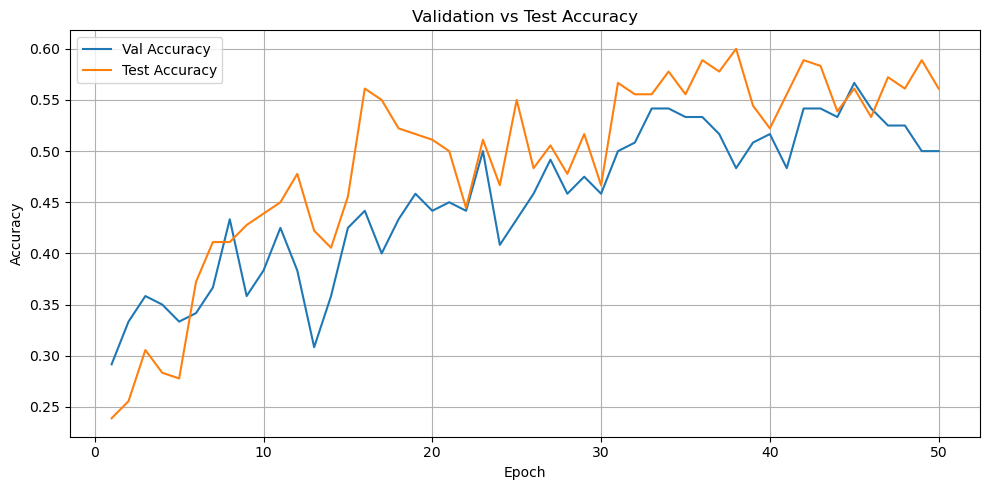


Best val acc: 0.5666666666666667
TEST (best checkpoint) | loss 0.2571 acc 0.9444

VISUAL ANALYSIS – FOLD 1


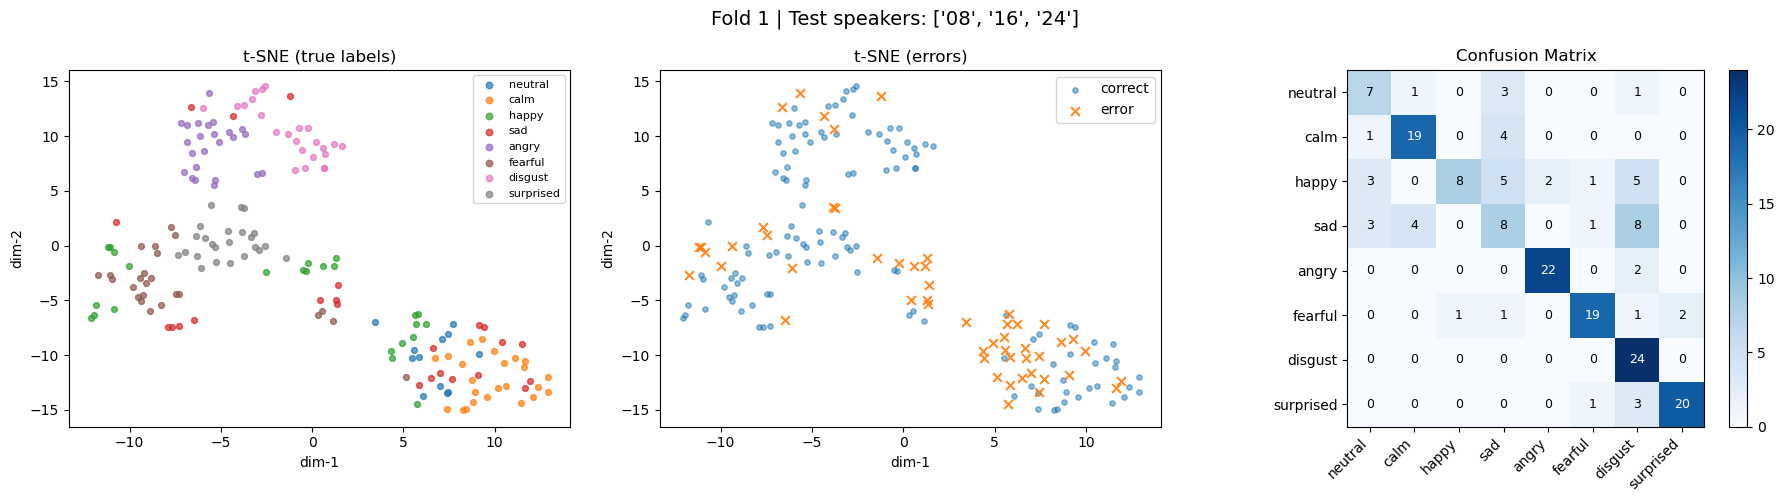

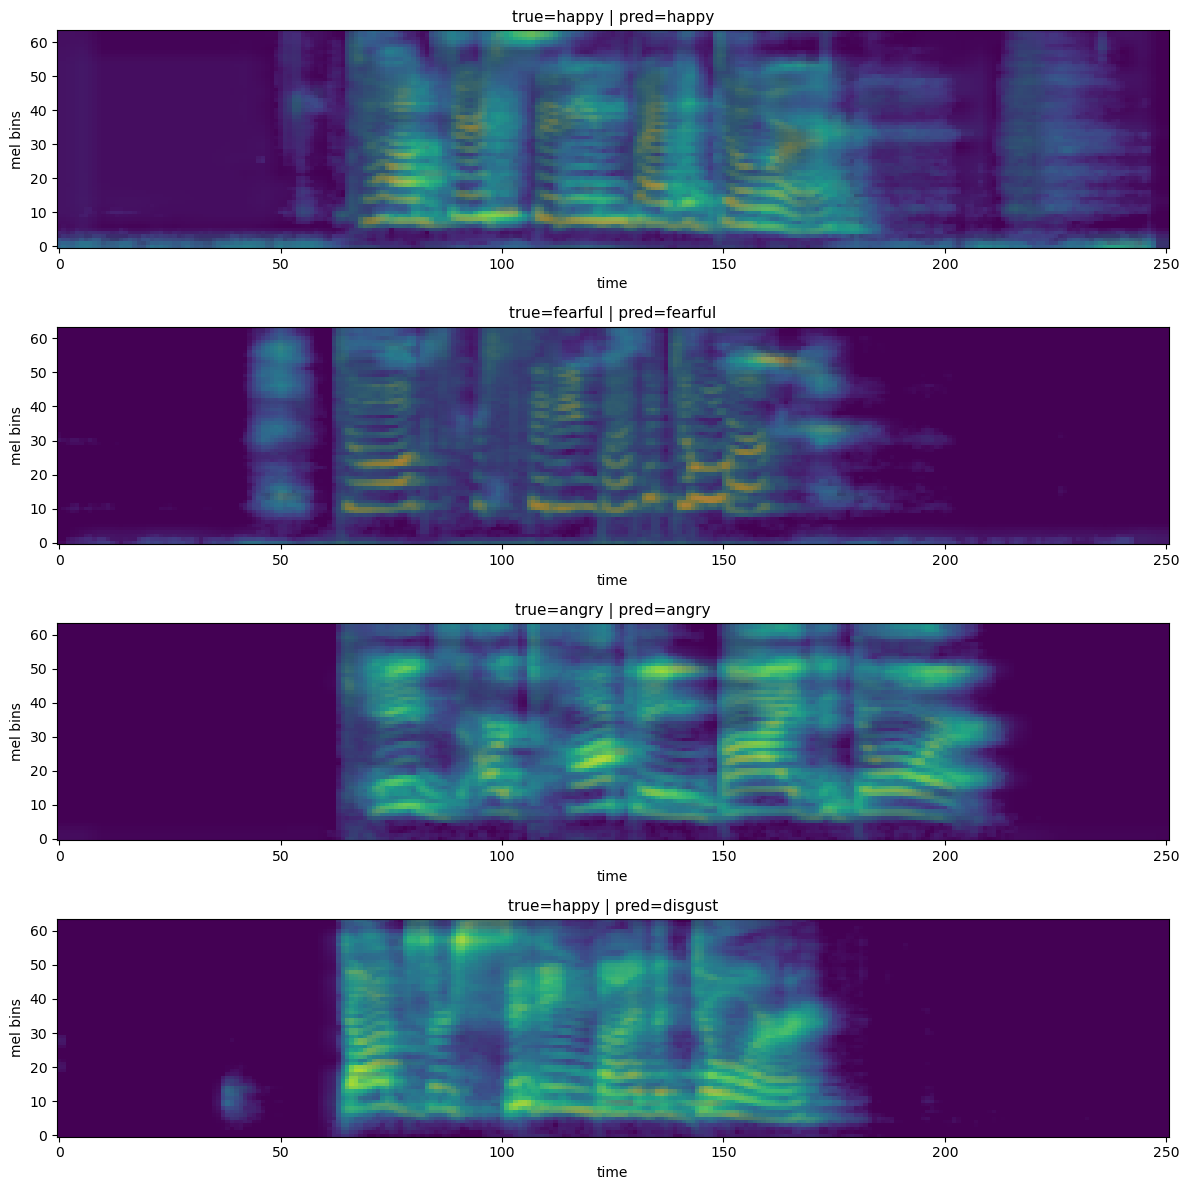


Classification report:
              precision    recall  f1-score   support

     neutral     0.5000    0.5833    0.5385        12
        calm     0.7917    0.7917    0.7917        24
       happy     0.8889    0.3333    0.4848        24
         sad     0.3810    0.3333    0.3556        24
       angry     0.9167    0.9167    0.9167        24
     fearful     0.8636    0.7917    0.8261        24
     disgust     0.5455    1.0000    0.7059        24
   surprised     0.9091    0.8333    0.8696        24

    accuracy                         0.7056       180
   macro avg     0.7245    0.6979    0.6861       180
weighted avg     0.7395    0.7056    0.6959       180


VISUAL ANALYSIS – FOLD 2


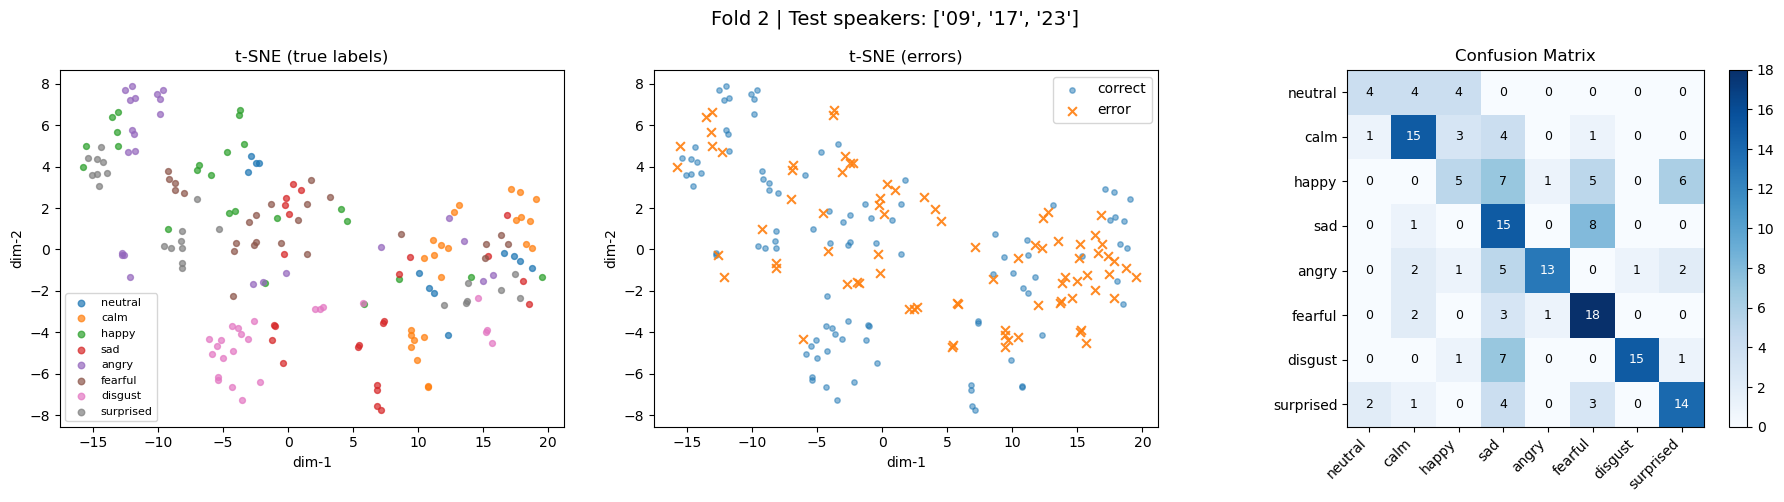

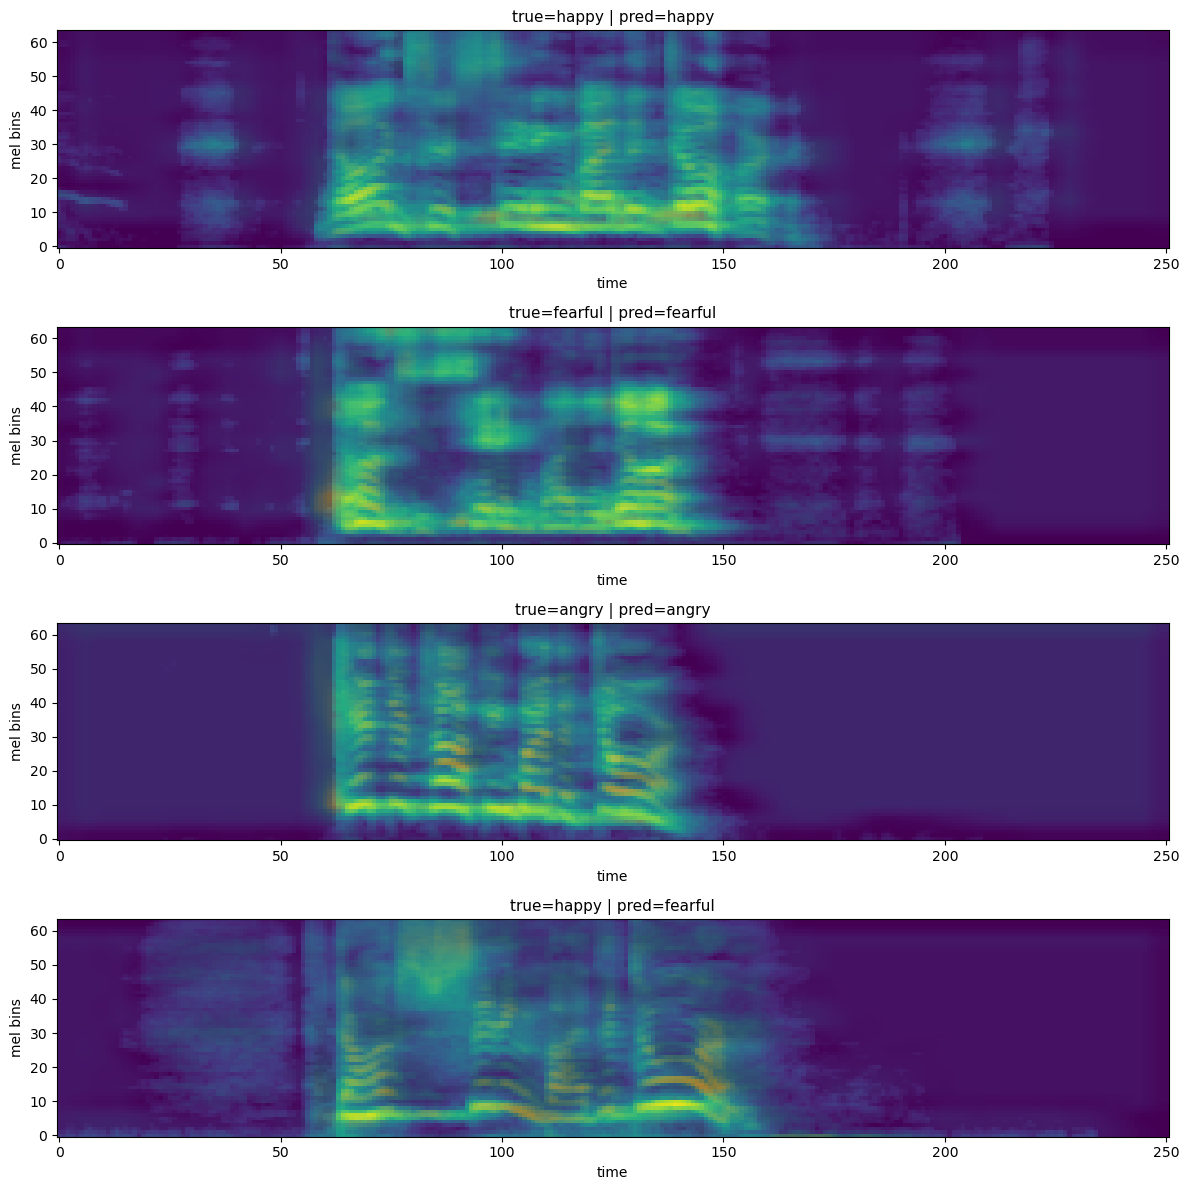


Classification report:
              precision    recall  f1-score   support

     neutral     0.5714    0.3333    0.4211        12
        calm     0.6000    0.6250    0.6122        24
       happy     0.3571    0.2083    0.2632        24
         sad     0.3333    0.6250    0.4348        24
       angry     0.8667    0.5417    0.6667        24
     fearful     0.5143    0.7500    0.6102        24
     disgust     0.9375    0.6250    0.7500        24
   surprised     0.6087    0.5833    0.5957        24

    accuracy                         0.5500       180
   macro avg     0.5986    0.5365    0.5442       180
weighted avg     0.6004    0.5500    0.5524       180


VISUAL ANALYSIS – FOLD 3


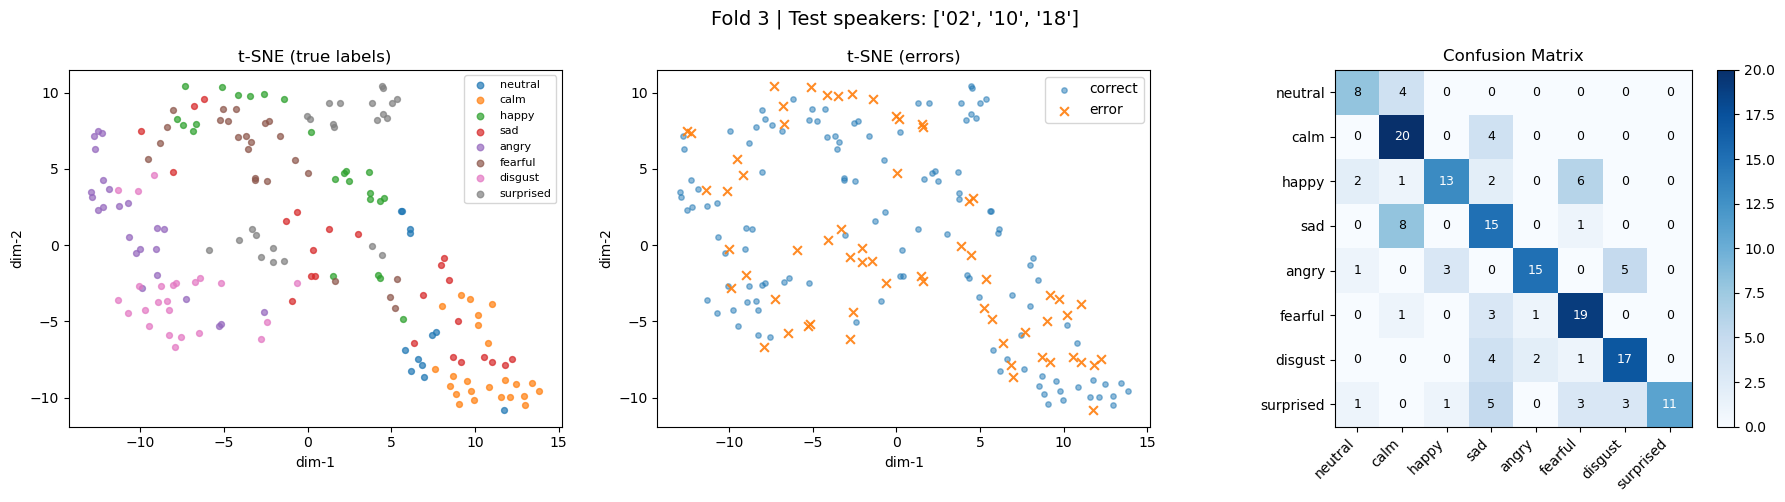

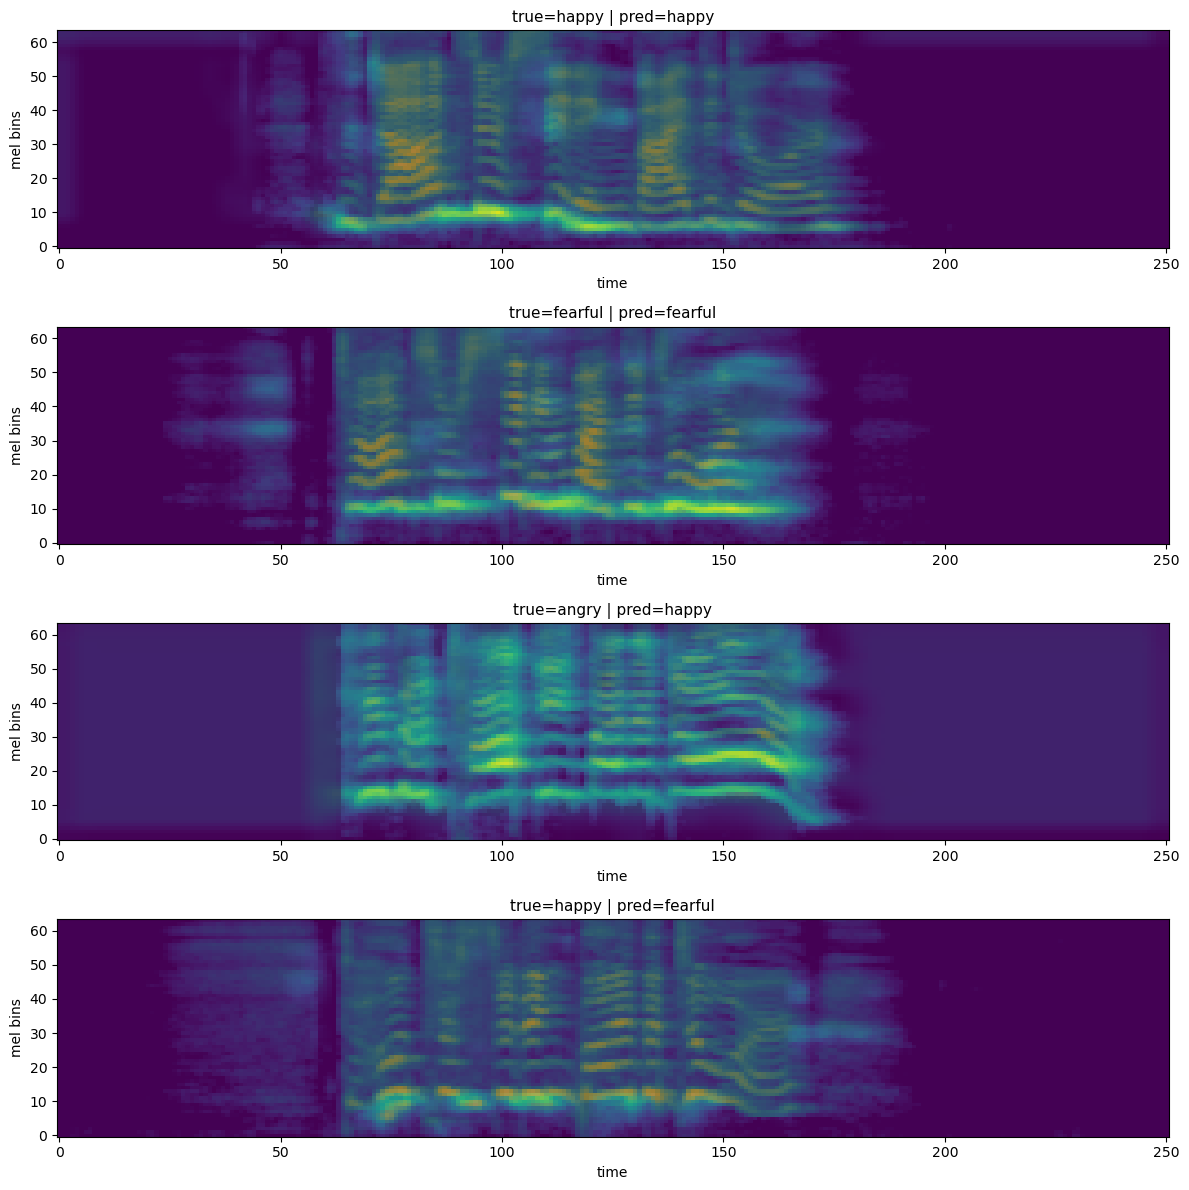


Classification report:
              precision    recall  f1-score   support

     neutral     0.6667    0.6667    0.6667        12
        calm     0.5882    0.8333    0.6897        24
       happy     0.7647    0.5417    0.6341        24
         sad     0.4545    0.6250    0.5263        24
       angry     0.8333    0.6250    0.7143        24
     fearful     0.6333    0.7917    0.7037        24
     disgust     0.6800    0.7083    0.6939        24
   surprised     1.0000    0.4583    0.6286        24

    accuracy                         0.6556       180
   macro avg     0.7026    0.6562    0.6572       180
weighted avg     0.7050    0.6556    0.6565       180


VISUAL ANALYSIS – FOLD 4


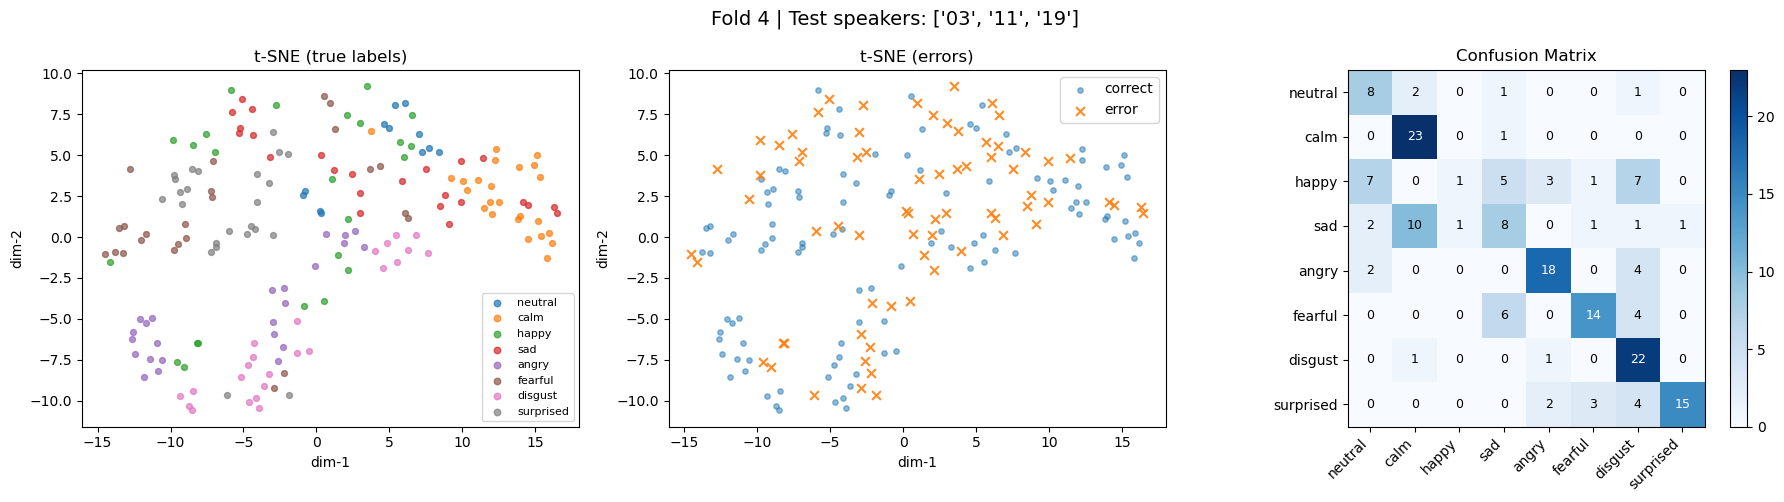

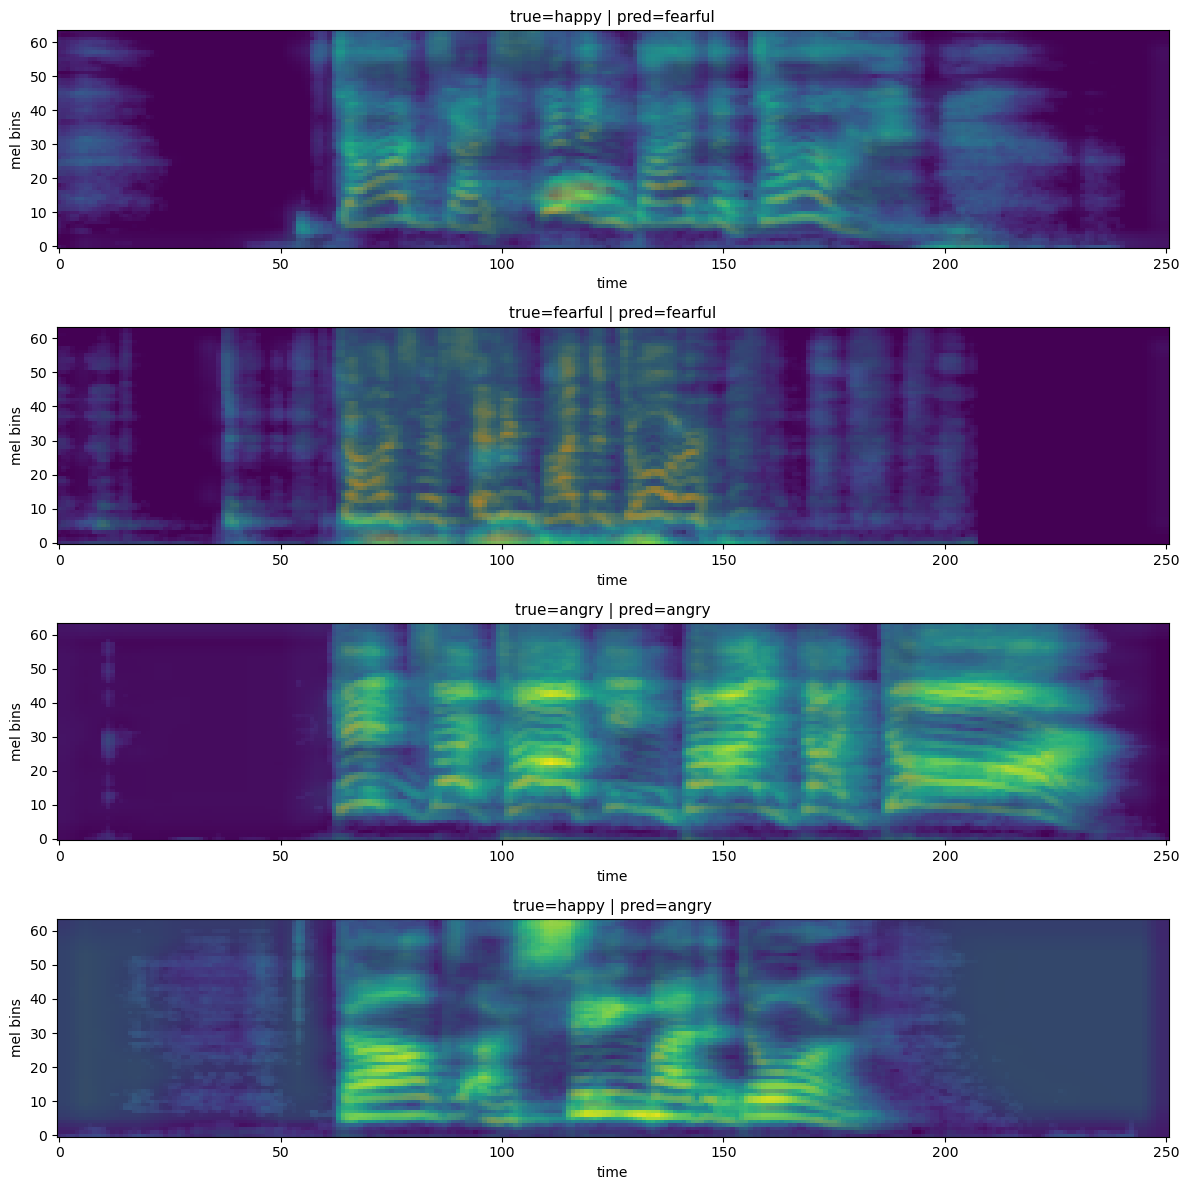


Classification report:
              precision    recall  f1-score   support

     neutral     0.4211    0.6667    0.5161        12
        calm     0.6389    0.9583    0.7667        24
       happy     0.5000    0.0417    0.0769        24
         sad     0.3810    0.3333    0.3556        24
       angry     0.7500    0.7500    0.7500        24
     fearful     0.7368    0.5833    0.6512        24
     disgust     0.5116    0.9167    0.6567        24
   surprised     0.9375    0.6250    0.7500        24

    accuracy                         0.6056       180
   macro avg     0.6096    0.6094    0.5654       180
weighted avg     0.6222    0.6056    0.5687       180


VISUAL ANALYSIS – FOLD 5


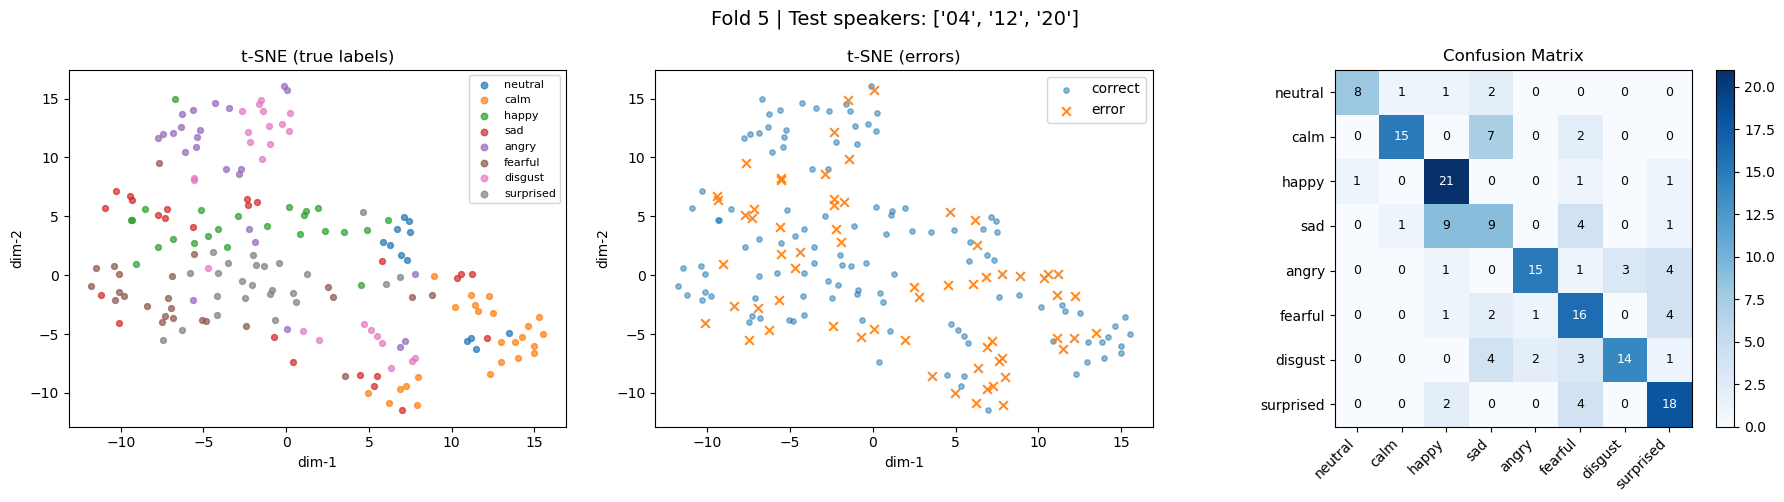

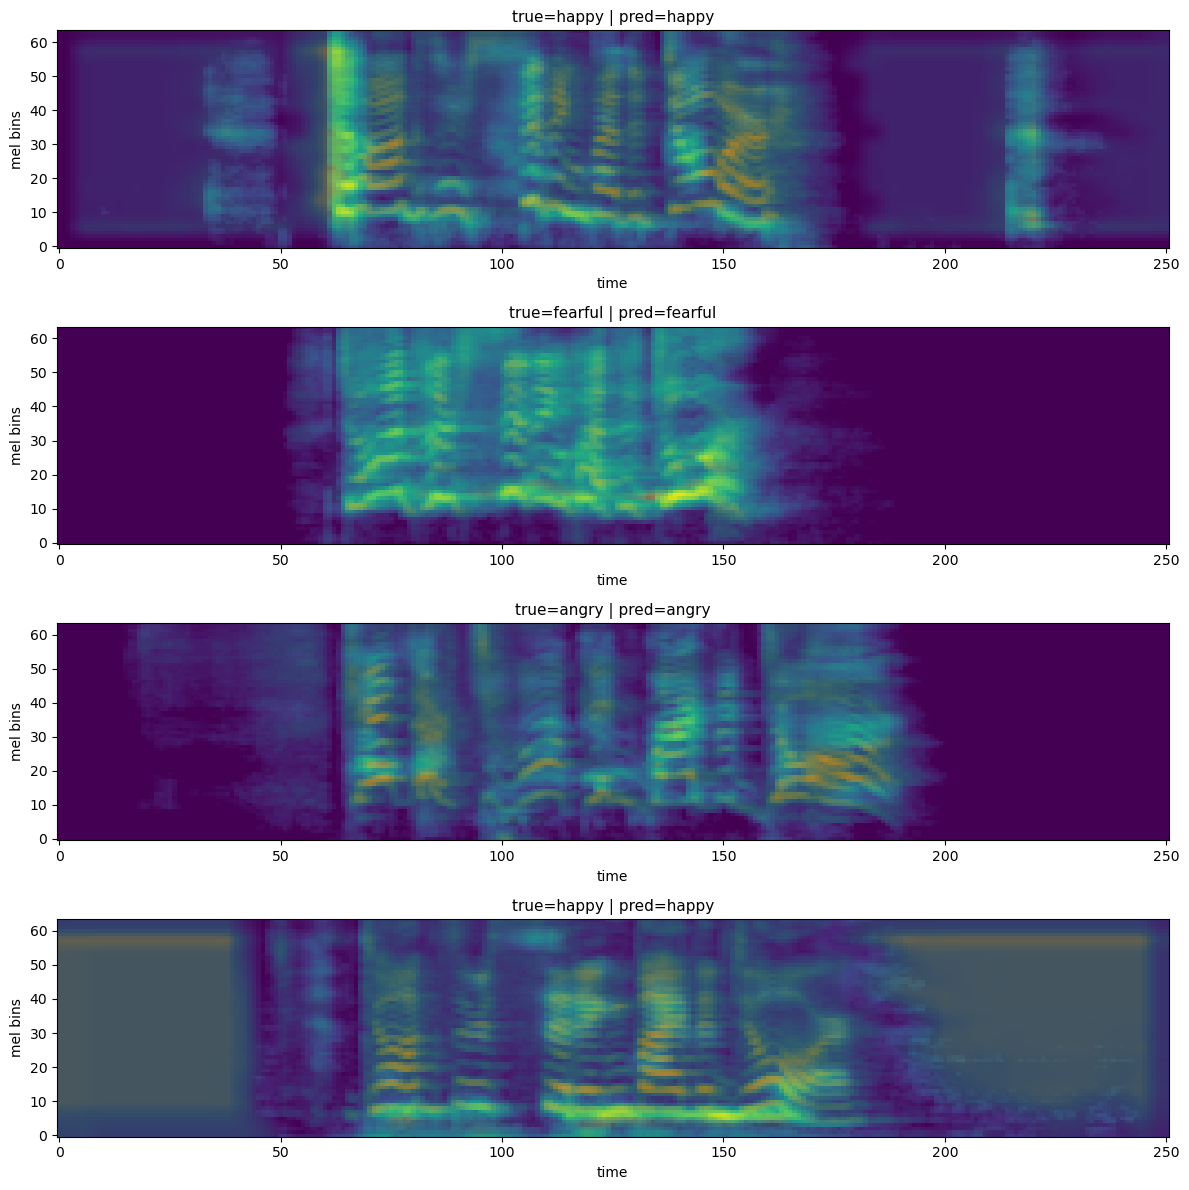


Classification report:
              precision    recall  f1-score   support

     neutral     0.8889    0.6667    0.7619        12
        calm     0.8824    0.6250    0.7317        24
       happy     0.6000    0.8750    0.7119        24
         sad     0.3750    0.3750    0.3750        24
       angry     0.8333    0.6250    0.7143        24
     fearful     0.5161    0.6667    0.5818        24
     disgust     0.8235    0.5833    0.6829        24
   surprised     0.6207    0.7500    0.6792        24

    accuracy                         0.6444       180
   macro avg     0.6925    0.6458    0.6548       180
weighted avg     0.6794    0.6444    0.6477       180


VISUAL ANALYSIS – FOLD 6


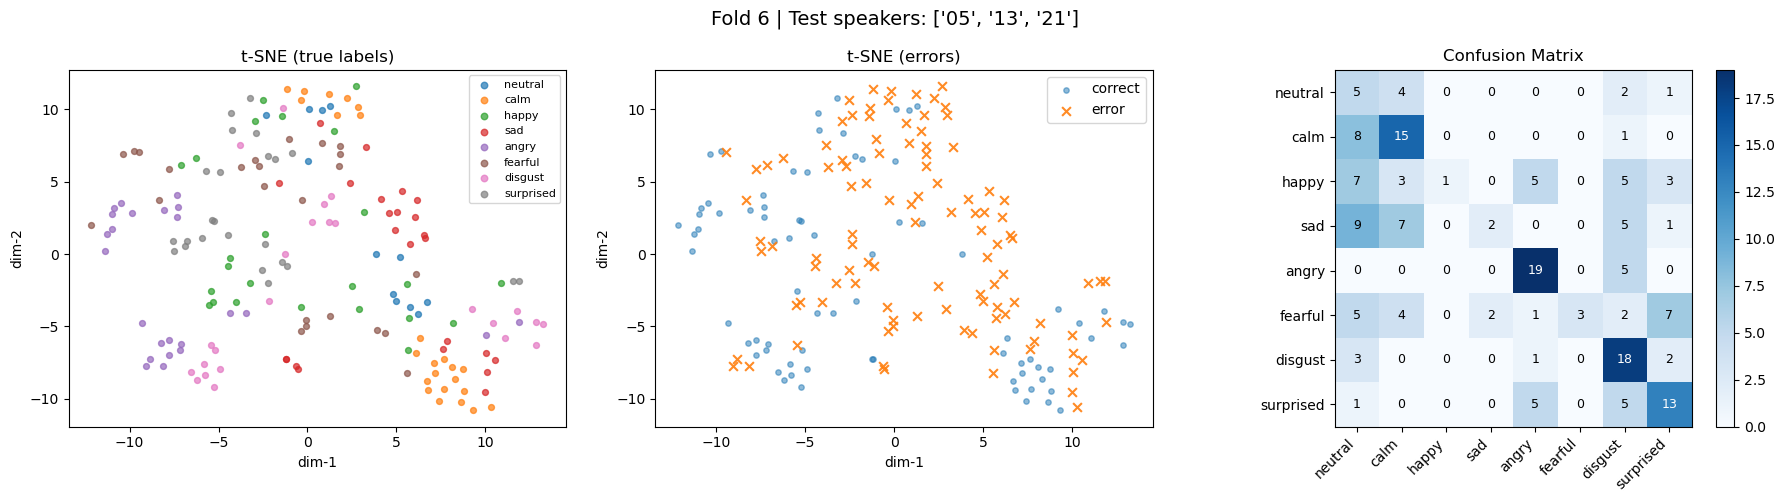

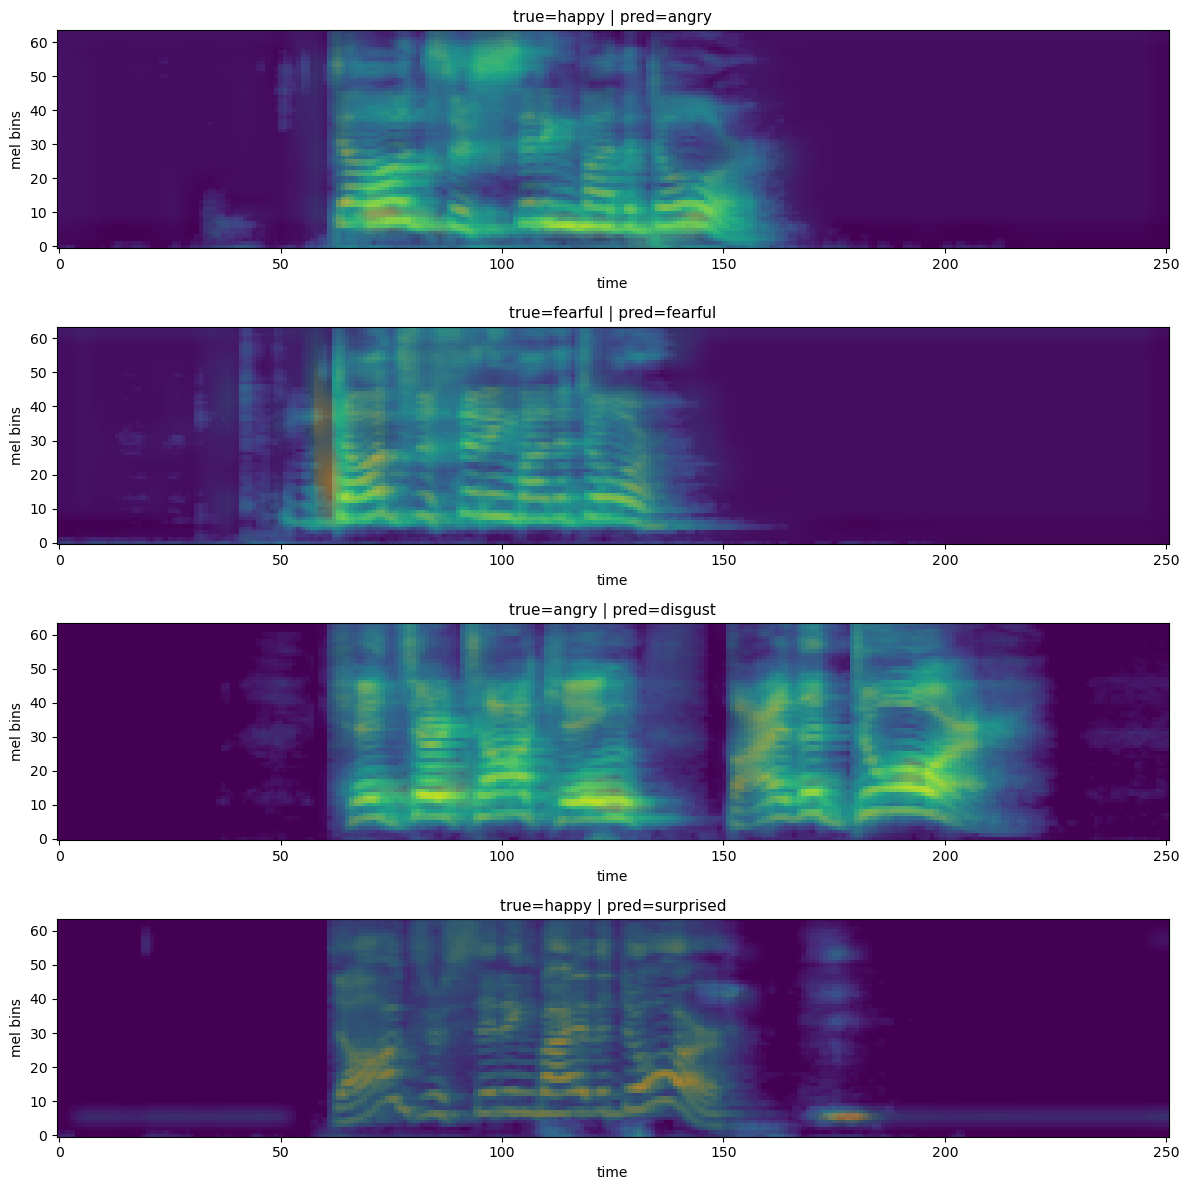


Classification report:
              precision    recall  f1-score   support

     neutral     0.1316    0.4167    0.2000        12
        calm     0.4545    0.6250    0.5263        24
       happy     1.0000    0.0417    0.0800        24
         sad     0.5000    0.0833    0.1429        24
       angry     0.6129    0.7917    0.6909        24
     fearful     1.0000    0.1250    0.2222        24
     disgust     0.4186    0.7500    0.5373        24
   surprised     0.4815    0.5417    0.5098        24

    accuracy                         0.4222       180
   macro avg     0.5749    0.4219    0.3637       180
weighted avg     0.6044    0.4222    0.3746       180


VISUAL ANALYSIS – FOLD 7


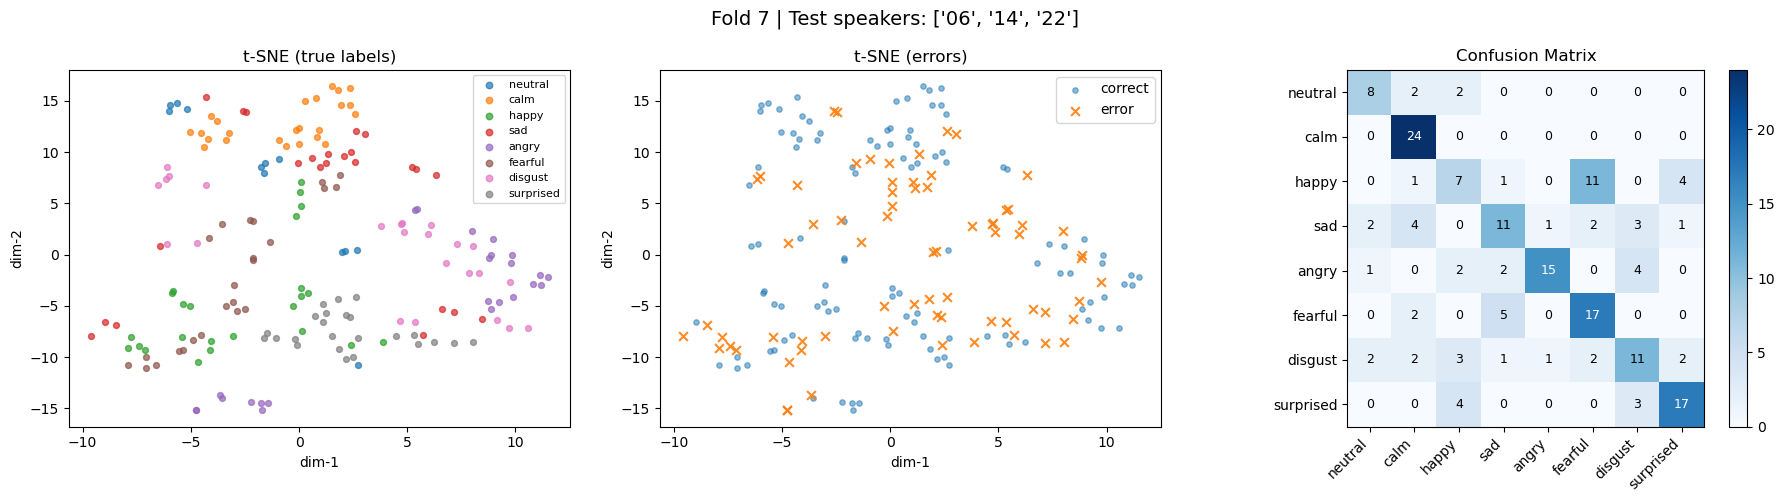

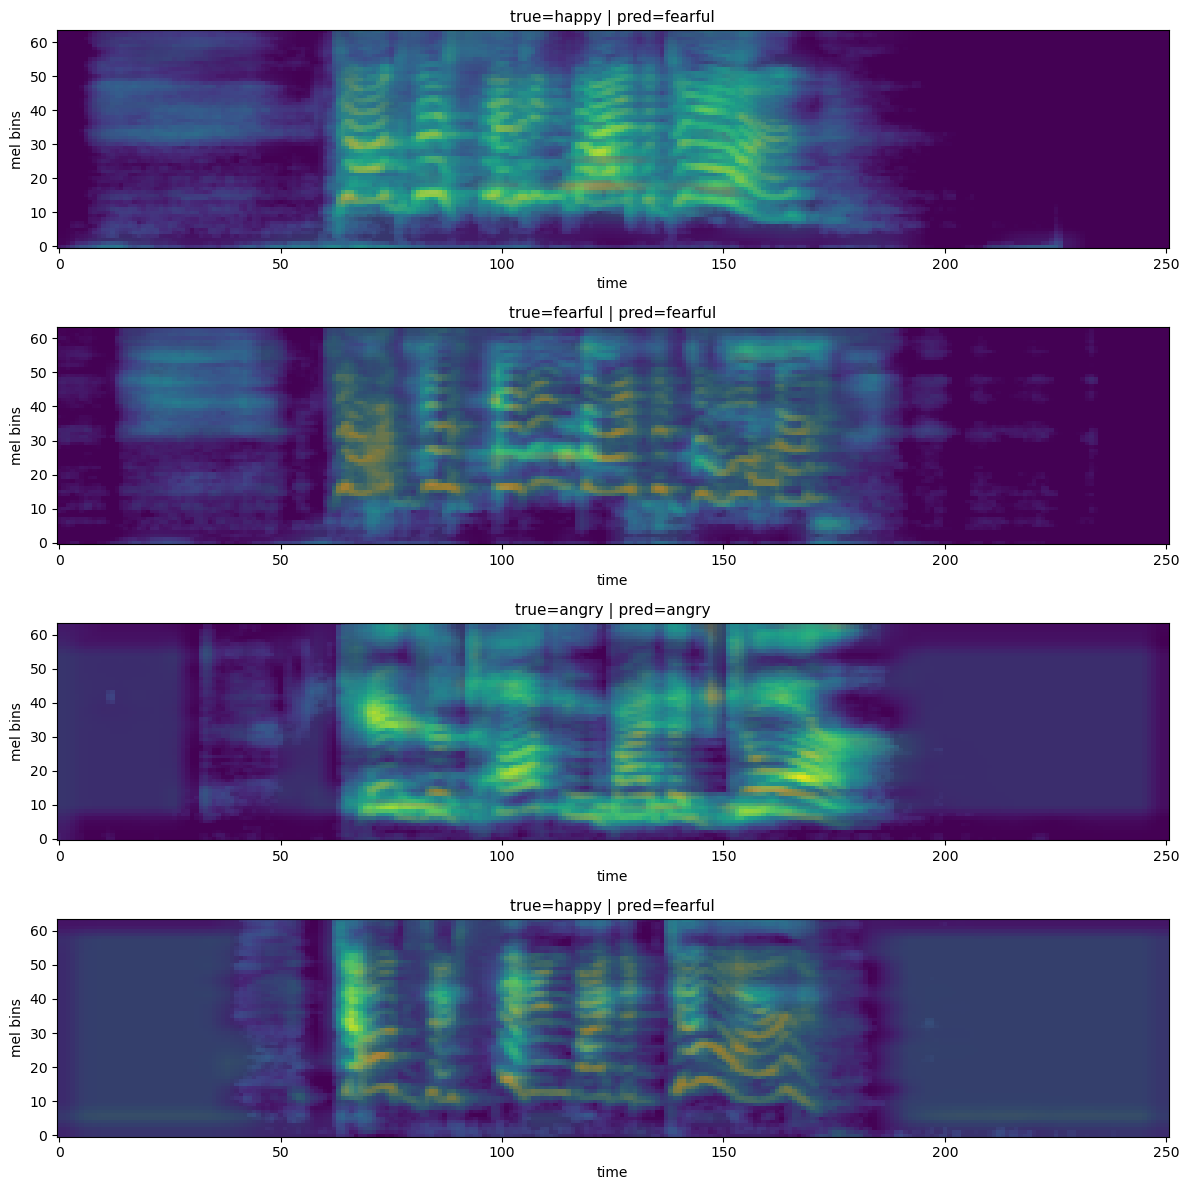


Classification report:
              precision    recall  f1-score   support

     neutral     0.6154    0.6667    0.6400        12
        calm     0.6857    1.0000    0.8136        24
       happy     0.3889    0.2917    0.3333        24
         sad     0.5500    0.4583    0.5000        24
       angry     0.8824    0.6250    0.7317        24
     fearful     0.5312    0.7083    0.6071        24
     disgust     0.5238    0.4583    0.4889        24
   surprised     0.7083    0.7083    0.7083        24

    accuracy                         0.6111       180
   macro avg     0.6107    0.6146    0.6029       180
weighted avg     0.6104    0.6111    0.6004       180


VISUAL ANALYSIS – FOLD 8


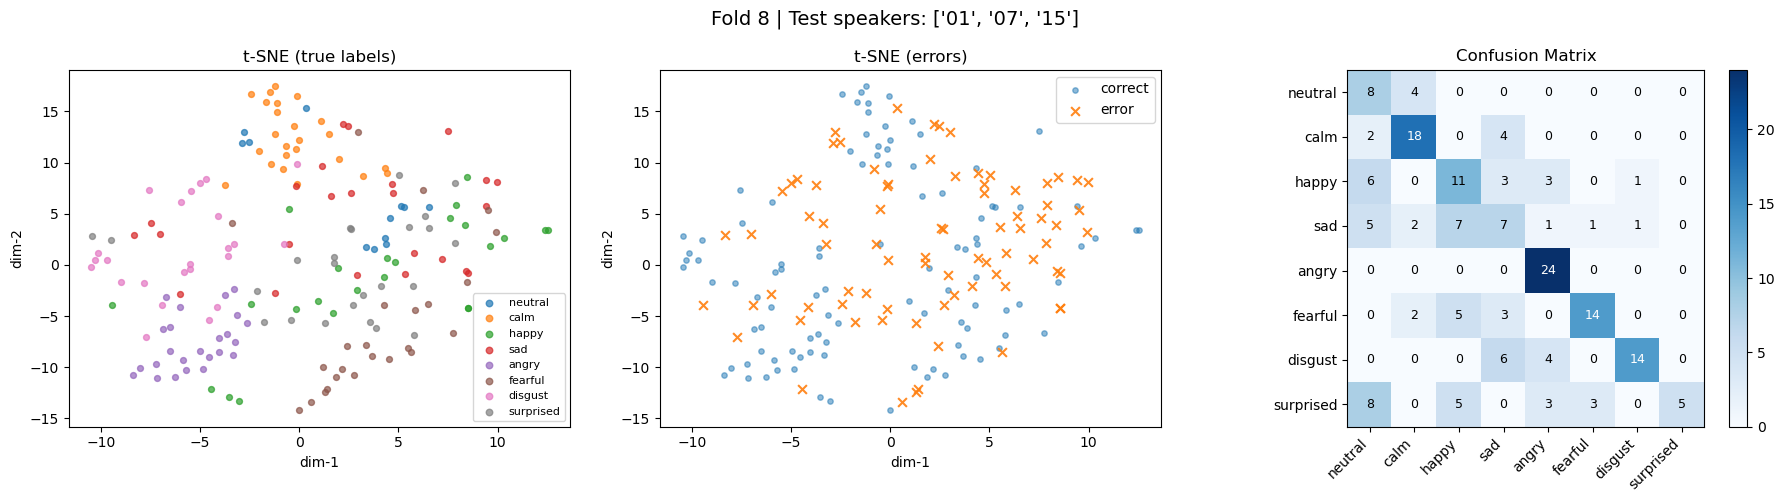

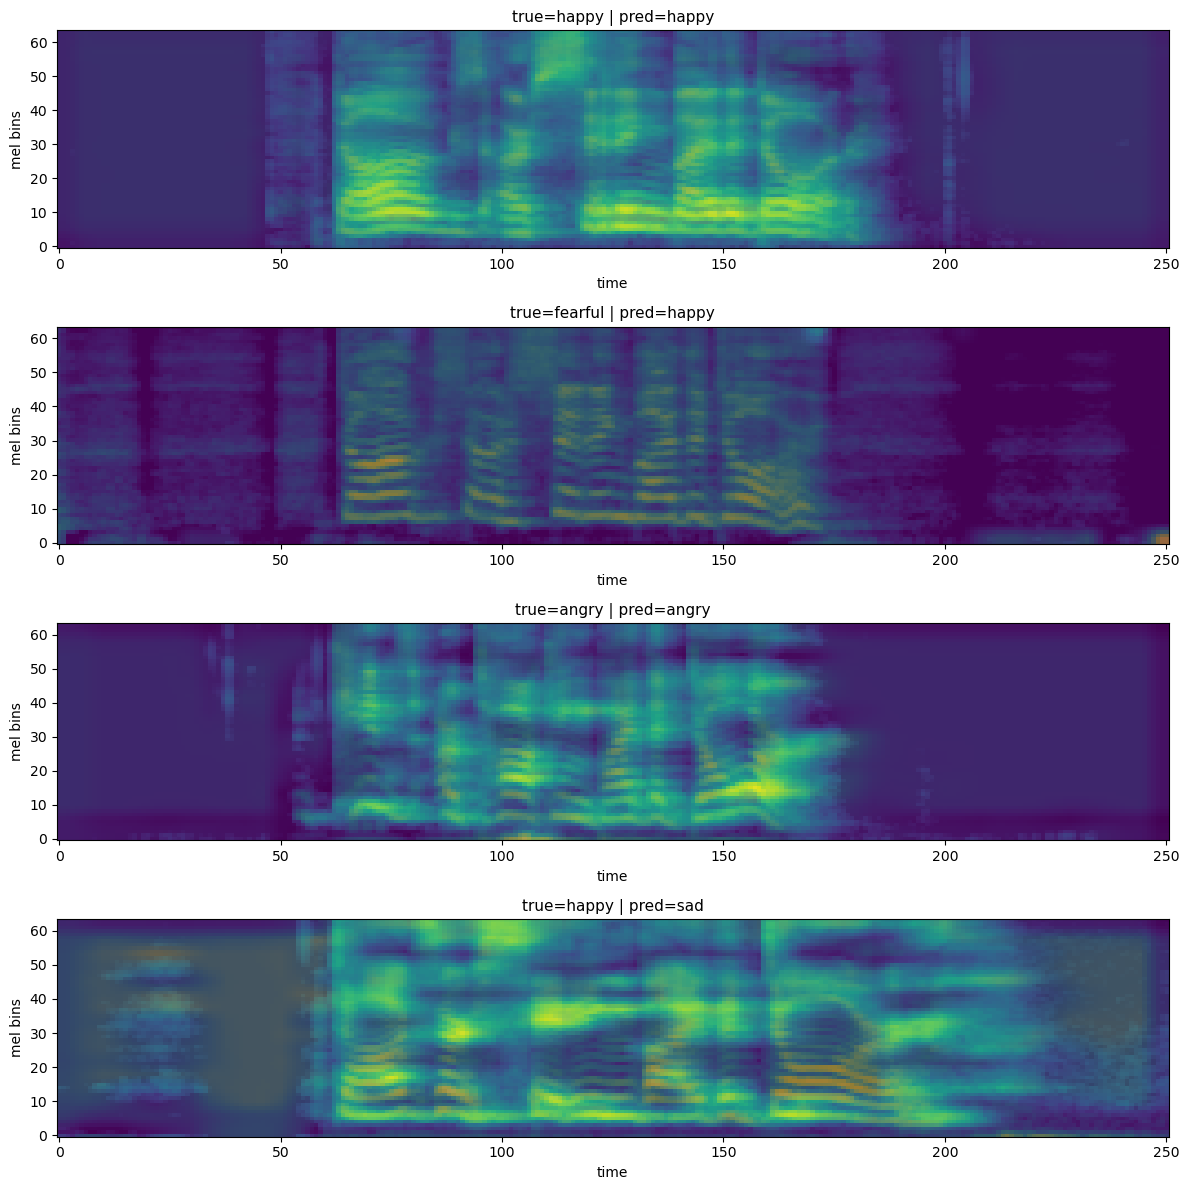


Classification report:
              precision    recall  f1-score   support

     neutral     0.2759    0.6667    0.3902        12
        calm     0.6923    0.7500    0.7200        24
       happy     0.3929    0.4583    0.4231        24
         sad     0.3043    0.2917    0.2979        24
       angry     0.6857    1.0000    0.8136        24
     fearful     0.7778    0.5833    0.6667        24
     disgust     0.8750    0.5833    0.7000        24
   surprised     1.0000    0.2083    0.3448        24

    accuracy                         0.5611       180
   macro avg     0.6255    0.5677    0.5445       180
weighted avg     0.6488    0.5611    0.5548       180



In [17]:

# Grafico accuracy train vs val
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_acc_hist, label="Val Accuracy")
plt.plot(epochs_range, test_acc_hist, label="Test Accuracy")
plt.title("Validation vs Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 7) test finale con best checkpoint
print("\nBest val acc:", best_val_acc)
model.load_state_dict(torch.load(best_path, map_location=device))

test_loss, test_acc = evaluate(model, test_loader, device)
print(f"TEST (best checkpoint) | loss {test_loss:.4f} acc {test_acc:.4f}")


def gradcam_summary(model, loader, device, n_examples=4, seed=42):
    """
    Mostra Grad-CAM su pochi esempi in una figura compatta.
    """
    rng = np.random.RandomState(seed)
    idxs = rng.choice(
        len(loader.dataset),
        size=min(n_examples, len(loader.dataset)),
        replace=False
    )

    target_layer = find_last_conv2d(model)
    cam_engine = GradCAM(model, target_layer)

    fig, axes = plt.subplots(len(idxs), 1, figsize=(12, 3 * len(idxs)))
    if len(idxs) == 1:
        axes = [axes]

    model.eval()
    for ax, i in zip(axes, idxs):
        spec, y = loader.dataset[i]
        x = spec.unsqueeze(0).to(device)
        y = int(y.item())

        cam, _, logits = cam_engine(x, class_idx=None)
        pred = int(logits.argmax(dim=1).item())

        spec_np = spec.squeeze(0).cpu().numpy()
        cam_np = cam.numpy()

        ax.imshow(spec_np, aspect="auto", origin="lower")
        ax.imshow(cam_np, aspect="auto", origin="lower", alpha=0.45)
        ax.set_title(
            f"true={IDX2LABEL[y]} | pred={IDX2LABEL[pred]}",
            fontsize=11
        )
        ax.set_xlabel("time")
        ax.set_ylabel("mel bins")

    plt.tight_layout()
    plt.show()
    cam_engine.close()

def plot_fold_summary(Z, y_true, y_pred, fold_idx, test_speakers):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # t-SNE – true labels
    ax = axes[0]
    for k in np.unique(y_true):
        idx = (y_true == k)
        ax.scatter(
            Z[idx, 0], Z[idx, 1],
            s=18, alpha=0.7,
            label=IDX2LABEL[int(k)]
        )
    ax.set_title("t-SNE (true labels)")
    ax.set_xlabel("dim-1")
    ax.set_ylabel("dim-2")
    ax.legend(fontsize=8, markerscale=1.1)

    # t-SNE – correct vs error
    ax = axes[1]
    correct = (y_true == y_pred)
    ax.scatter(
        Z[correct, 0], Z[correct, 1],
        s=15, alpha=0.5, label="correct"
    )
    ax.scatter(
        Z[~correct, 0], Z[~correct, 1],
        s=40, alpha=0.9, marker="x", label="error"
    )
    ax.set_title("t-SNE (errors)")
    ax.set_xlabel("dim-1")
    ax.set_ylabel("dim-2")
    ax.legend()

    # Confusion Matrix
    ax = axes[2]
    cm = confusion_matrix(y_true, y_pred)
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title("Confusion Matrix")

    tick_marks = np.arange(len(IDX2LABEL))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels([IDX2LABEL[i] for i in tick_marks], rotation=45, ha="right")
    ax.set_yticklabels([IDX2LABEL[i] for i in tick_marks])

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=9
            )

    fig.colorbar(im, ax=ax, fraction=0.046)

    # Titolo globale
    fig.suptitle(
        f"Fold {fold_idx + 1} | Test speakers: {test_speakers}",
        fontsize=14
    )

    plt.tight_layout()
    plt.show()


# LOOP SU TUTTI I FOLD
gkf = GroupKFold(n_splits=N_FOLDS)
splits = list(gkf.split(all_files, labels, groups=actors))

for fold_idx in range(N_FOLDS):
    print("\n" + "=" * 80)
    print(f"VISUAL ANALYSIS – FOLD {fold_idx + 1}")
    print("=" * 80)

    # Test loader del fold
    _, test_idx = splits[fold_idx]
    test_files = [all_files[i] for i in test_idx]
    test_speakers = sorted({actors[i] for i in test_idx})

    test_ds = RavdessDataset(test_files, augmentation=False)
    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # Modello del fold
    model = CRNN(n_classes=8, n_mels=64).to(device)
    model.load_state_dict(
        torch.load(f"best_fold_{fold_idx}.pt", map_location=device)
    )
    model.eval()

    # Embeddings + t-SNE
    emb, y_true_e, y_pred_e, _ = extract_crnn_embeddings(
        model, test_loader, device, return_paths=False
    )

    Z = tsne_project(
        emb,
        pca_dim=50,
        tsne_perplexity=30,
        seed=42
    )

    # Figura compatta
    plot_fold_summary(
        Z,
        y_true_e,
        y_pred_e,
        fold_idx,
        test_speakers
    )

    # gradcam

    gradcam_summary(
        model,
        test_loader,
        device,
        n_examples=4,   # 3–4 è perfetto
        seed=42
    )

    # Report testuale 
    print("\nClassification report:")
    target_names = [IDX2LABEL[i] for i in range(8)]
    print(classification_report(
        y_true_e, y_pred_e,
        target_names=target_names,
        digits=4
    ))


